# Digit Recognition with MNIST dataset

## Introduction

This notebook demonstrates how to build a simple feedforward neural network (with one hidden layer) and train it from scratch with NumPy to recognize handwritten digit images. Based on the image inputs and their labels (supervised learning), the neural network will be trained to learn their features using forward propagation and backpropagation (reverse-mode differentiation). The final output of the network is a vector of 10 scores — one for each handwritten digit image. Furthermore, the accuracy regarding how good your model is at classifying the images on the test set will also be evaluated.

## Requirements

Some basic knowledge of Python, NumPy array manipulation, and linear algebra will be necessary to follow along this notebook. In addition, familiarity with main concepts of deep learning is also expected.

In addition to NumPy, the following Python standard modules will also be utilized for data loading and processing:

* `urllib` for URL handling
* `requests` for URL opening
* `gzip` for gzip file decompression
* `pickle` to work with the pickle file format
* `Matplotlib` for data visualization

#### 1. Load the MNIST dataset

In this section, the zipped MNIST dataset files will be downloaded which are originally stored in Yann LeCun’s website. Then, they will be transformed into 4 files of NumPy array type using built-in Python modules. Finally, the arrays will be splitted into training and test sets.

In [1]:
import os
import gzip
import requests
import numpy as np
import matplotlib.pyplot as plt

1.  Define a variable to store the training/test image/label names of the MNIST dataset in a list:

In [2]:
data_sources = {
    'training_images': 'train-images-idx3-ubyte.gz',    # 60,000 training images.
    'test_images': 't10k-images-idx3-ubyte.gz',         # 10,000 test images.
    'training_labels': 'train-labels-idx1-ubyte.gz',    # 60,000 training labels.
    'test_labels': 't10k-labels-idx1-ubyte.gz',         # 10,000 test labels.
}

2. Load the data. First check if the data is stored locally; if not, then download it.

In [3]:
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0'
}

request_opts = {
    'headers': headers,
    'params': {'raw': 'true'},
}

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [4]:
base_url = 'https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/'

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print('Downloading file:', fname)
        response = requests.get(base_url + fname, stream=True, **request_opts)
        response.raise_for_status() # Ensures successful download
        
        with open(fpath, 'wb') as writer:
            for chunk in response.iter_content(chunk_size=128):
                writer.write(chunk)

3. Decompress the 4 files and create 4 ndarrays, saving them into a dictionary. Each original image is of size 28x28 and neural networks normally expect a 1D vector input; therefore, you also need to reshape the images by multiplying 28 by 28 (784).

In [5]:
mnist_dataset = {}

# images
for key in ('training_images', 'test_images'):
    with gzip.open(os.path.join(data_dir, data_sources[key]), 'rb') as reader:
        mnist_dataset[key] = np.frombuffer(reader.read(), np.uint8, offset=16).reshape(-1, 28 * 28)

# labels
for key in ('training_labels', 'test_labels'):
    with gzip.open(os.path.join(data_dir, data_sources[key]), 'rb') as reader:
        mnist_dataset[key] = np.frombuffer(reader.read(), np.uint8, offset=8)

4. Split the data into training and test sets using the standard notation of x for data and y for labels, calling the training and test set images x_train and x_test, and the labels y_train and y_test:

In [6]:
x_train, y_train, x_test, y_test = (
    mnist_dataset['training_images'],
    mnist_dataset['training_labels'],
    mnist_dataset['test_images'],
    mnist_dataset['test_labels'],
)

5. Verify that the shape of the image arrays is (60000, 784) and (10000, 784) for training and test sets, respectively, and the labels — (60000,) and (10000,):

In [7]:
print(f'The shape of training images: {x_train.shape} and training labels: {y_train.shape}')
print(f'The shape of test images: {x_test.shape} and test labels: {y_test.shape}')

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


6. Inspect some images using `matplotlib`

label of 60000th image 8


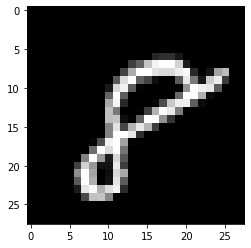

In [8]:
# Take 60000th image (indexed at 59999) from the training set, reshape from (784,)
# to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)

# Display the label of the 60,000th image (indexed at 59,999) from the training set.
print('label of 60000th image', y_train[59999])

# set the color mapping to grayscale to have a black background
plt.imshow(mnist_image, cmap='gray')
plt.show()

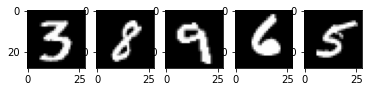

In [9]:
# Display 5 random images from the training set
num_examples = 5
seed = 147197952744 # used for reproducing the same indexes
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(x_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap='gray')

#### 2. Preprocess data

Neural networks can work with inputs that are in a form of tensors (multidimensional arrays) of floating-point type. When preprocessing the data, the following processes should be considered: `vectorization` and `conversion to a floating-point format`. Since the MNIST data is already vectorized and the arrays are of dtype `uint8`, the next task is to convert them to a floating-point format, such as `float64` (double-precision):

* `Normalization` on the image data: a `feature scaling` procedure that can speed up the neural network training process by applying `standardization` on the distribution of your input data.
* `One-hot/categorical encoding` of the image labels.

##### Convert the image data to the floating-point format

The images data contain 8-bit integers encoded in the [0, 255] interval with color values between 0 and 255. They will be required to be normalized into floating-point arrays in the [0, 1] interval by dividing them by 255.

1. Check that the vectorized image data has type `uint8`:

In [10]:
print(f'The data type of training images: {x_train.dtype}')
print(f'The data type of test images: {x_test.dtype}')

The data type of training images: uint8
The data type of test images: uint8


2. Normalize the arrays by dividing them by 255 (and thus promoting the data type from `uint8` to `float64`) and then assign the train and test image data variables — `x_train` and `x_test` — to `training_images` and `train_labels`, respectively. To reduce the model training and evaluation time in this example, only a subset of the training and test images will be used. Both `training_images` and `test_images` will contain only 5000 samples each out of the complete datasets of 60000 and 10000 images, respectively. These values can be controlled by changing the `training_sample` and `test_sample` below, up to their maximum values of 60000 and 10000.

In [11]:
training_sample, test_sample = 5000, 5000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

3. Verify that the image data has changed to the floating-point format:

In [12]:
print(f'The data type of the training images: {training_images.dtype}')
print(f'The data type of the test images: {test_images.dtype}')

The data type of the training images: float64
The data type of the test images: float64


##### Convert the labels to floating point through categorical/one-hot encoding

One-hot encoding will be used to embed each digit label as an all-zero vector with `np.zeros()` and 1 will be placed for a label index. As a result, the label data will be arrays with 1.0 (or 1.) in the position of each image label. Since there are 10 labels (from 0 to 9) in total, the arrays will look similar to this:

`array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])`

1. Confirm that the image label data are integers with dtype `uint8`:

In [13]:
print(f'The data type of the training labels: {y_train.dtype}')
print(f'The data type of the test labels: {y_test.dtype}')

The data type of the training labels: uint8
The data type of the test labels: uint8


2. Define a function that performs one-hot encoding on arrays:

In [14]:
def one_hot_encoding(labels, dimension=10):
    """Define a one-hot variable for an all-zero vector
    with 10 dimensions (number labels from 0 to 9).
    """
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    return one_hot_labels.astype(np.float64)

3. Encode the labels and assign the values to new variables:

In [15]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

4. Check that the data type has changed to floating point:

In [16]:
print(f'The data type of training labels: {training_labels.dtype}')
print(f'The data type of test labels: {test_labels.dtype}')

The data type of training labels: float64
The data type of test labels: float64


In [17]:
print('encoded:', training_labels[0], 'original:', y_train[0])
print('encoded:', training_labels[1], 'original:', y_train[1])
print('encoded:', training_labels[2], 'original:', y_train[2])

encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] original: 5
encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] original: 0
encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] original: 4


#### 3. Build and train a small neural network from scratch

In this section, some high-level concepts of the basic building blocks of a deep learning model will be demonstrated. Afterwards, the building blocks of a simple deep learning model will be constructed using Python and NumPy and trained to learn to identify handwritten digits from the MNIST dataset with a certain level of accuracy.

##### Neural network building blocks with NumPy

* _Layers_: These building blocks work as data filters — they process data and learn representations from inputs to better predict the target outputs. Here, 1 hidden layer will be used in the model to pass the inputs forward (forward propagation) and propagate the gradients/error derivatives of a loss function backward (backpropagation). These are input, hidden and output layers. In the hidden (middle) and output (last) layers, the neural network model will compute the weighted sum of inputs. To compute this process, NumPy’s matrix multiplication function (the "dot multiply" or `np.dot(layer, weights)`) will be used.

    > *Note: For simplicity, the bias term is omitted in this example (there is no np.dot(layer, weights) + bias).*

* _Weights_: These are important adjustable parameters that the neural network fine-tunes by forward and backward propagating the data. They are optimized through a process called `gradient descent`. Before the model training starts, the weights are randomly initialized with NumPy’s `Generator.random()`. The optimal weights should produce the highest prediction accuracy and the lowest error on the training and test sets.

* _Activation function_: Deep learning models are capable of determining non-linear relationships between inputs and outputs and these non-linear functions are usually applied to the output of each layer. A `rectified linear unit (ReLU)` will be applied to the hidden layer’s output (for example, `relu(np.dot(layer, weights)`).

* _Regularization_: This technique helps prevent the neural network model from `overfitting`. In this example, a method called dropout — dilution — will be used that randomly sets a number of features in a layer to 0s. It will be defined with NumPy’s `Generator.integers()` method and apply it to the hidden layer of the network.

* _Loss function_: The computation determines the quality of predictions by comparing the image labels (the truth) with the predicted values in the final layer’s output. For simplicity, a basic total squared error will be used using NumPy’s `np.sum()` function (for example, `np.sum((final_layer_output - image_labels) ** 2))`.

* _Accuracy_: This metric measures the accuracy of the network’s ability to predict on the data it hasn’t seen.

##### Model architecture and training summary

* _The input layer_: It is the input for the network — the previously preprocessed data that is loaded from `training_images` into `layer_0`.

* _The hidden (middle) layer_: `layer_1` takes the output from the previous layer and performs matrix-multiplication of the input by weights `(weights_1)` with NumPy’s `np.dot()`. Then, this output is passed through the ReLU activation function for non-linearity and then dropout is applied to help with overfitting.

* _The output (last) layer_: `layer_2` ingests the output from `layer_1` and repeats the same `dot multiply` process with `weights_2`. The final output returns 10 scores for each of the 0-9 digit labels. The network model ends with a size 10 layer — a 10-dimensional vector.

* _Forward propagation, Backpropagation, training loop_: In the beginning of model training, the network randomly initializes the weights and feeds the input data forward through the hidden and output layers. This process is the forward pass or forward propagation.

    Then, the network propagates the `signal` from the loss function back through the hidden layer and adjusts the weights values with the help of the learning rate parameter (more on that later).

    >   **Note**: In more technical terms, this is what happens:
    >
    >       1. Measure the error by comparing the real label of an image (the truth) with the prediction of the model.
    >
    >       2. Differentiate the loss function.
    >
    >       3. Ingest the `gradients` with the respect to the output, and backpropagate them with the respect to the inputs through the layer(s).
    >
    > Since the network contains tensor operations and weight matrices, backpropagation uses the `chain rule`. With each iteration (epoch) of the neural network training, this forward and backward propagation cycle adjusts the weights, which is reflected in the accuracy and error metrics. As the model is trained, the goal is to minimize the error and maximize the accuracy on the training data, where the model learns from, as well as the test data, where the model is evaluated.

##### Compose the model and begin training and testing it

1. Start by creating a new random number generator, providing a seed for reproducibility:

In [18]:
seed = 884736743
rng = np.random.default_rng(seed)

2. For the hidden layer, define the ReLU activation function for forward propagation and ReLU’s derivative that will be used during backpropagation:

In [19]:
# Define ReLU that returns the input if it's positive and 0 otherwise.
def relu(x):
    return (x >= 0) * x

In [20]:
# Set up a derivative of the ReLU function that returns 1 for a positive input and 0 otherwise
def relu2deriv(output):
    return output >= 0

3. Set certain default values of `hyperparameters`, such as:

* _Learning rate_: `learning_rate` — helps limit the magnitude of weight updates to prevent them from overcorrecting.

* _Epochs (iterations)_: `epochs` — the number of complete passes — forward and backward propagations — of the data through the network. This parameter can positively or negatively affect the results. The higher the iterations, the longer the learning process may take. Because this is a computationally intensive task, a very low number of epochs (20) was chosen. To get meaningful results, a much larger number should be chosen.

* _Size of the hidden (middle) layer in a network_: `hidden_size` — different sizes of the hidden layer can affect the results during training and testing.

* _Size of the input_: `pixels_per_image` — the image input is 784 (28x28) (in pixels) has already been determined.

* _Number of labels_: `num_labels` — indicates the output number for the output layer where the predictions occur for 10 (0 to 9) handwritten digit labels.

In [21]:
# hyper-parameters
learning_rate = 0.005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

4. Initialize the weight vectors that will be used in the hidden and output layers with random values:

In [22]:
weights_1 = 0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1
weights_2 = 0.2 * rng.random((hidden_size, num_labels)) - 0.1

5. Set up the neural network’s learning experiment with a training loop and start the training process. Note that the model is evaluated against the test set at each epoch to track its performance over the training epochs.

In [23]:
# To store training and test set losses and accurate predictions for visualization
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

In [24]:
# training loop starts here
for j in range(epochs):
    
    #################
    # Training step #
    #################
    
    # Set the initial loss/error and the number of accurate predictions to zero
    training_loss = 0.0
    training_accurate_predictions = 0
    
    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly
    for i in range(len(training_images)):
        # Forward propagation/forward pass
        # 1. The input layer
        #    Initialize the training image data as inputs
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights
        layer_1 = np.dot(layer_0, weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 5. Apply dropout to the hidden layer's output
        layer_1 *= dropout_mask * 2
        # 6. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights
        #    Produce a 10-dimensional vector with 10 scores
        layer_2 = np.dot(layer_1, weights_2)
        
        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model
        training_loss += np.sum((training_labels[i] - layer_2) ** 2)
        # 2. Increment the accurate prediction count
        training_accurate_predictions += int(np.argmax(layer_2) == np.argmax(training_labels[i]))
        # 3. Differentiate the loss function/error
        layer_2_delta = training_labels[i] - layer_2
        # 4. Propagate the gradients of the loss function back through the hidden layer
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)
    
    # Store training set losses and accurate predictions
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)
    
    ###################
    # Evaluation step #
    ###################
    
    # Evaluate model performance on the test set at each epoch
    
    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image individually:
    results = relu(test_images @ weights_1) @ weights_2
    
    # Measure the error between the actual label (truth) and prediction values
    test_loss = np.sum((test_labels - results) ** 2)
    
    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(np.argmax(results, axis=1) == np.argmax(test_labels, axis=1))
    
    # Store test set losses and accurate predictions
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)
    
    # Summarize error and accuracy metrics at each epoch
    print(
        '\n'
        + 'Epoch: ' + str(j)
        + ' Training set error:' + str(training_loss / float(len(training_images)))[:5]
        + ' Training set accuracy:' + str(training_accurate_predictions / float(len(training_images)))
        + ' Test set error:' + str(test_loss / float(len(test_images)))[:5]
        + ' Test set accuracy:' + str(test_accurate_predictions / float(len(test_images)))
    )


Epoch: 0 Training set error:0.664 Training set accuracy:0.5928 Test set error:0.514 Test set accuracy:0.732

Epoch: 1 Training set error:0.515 Training set accuracy:0.7254 Test set error:0.461 Test set accuracy:0.793

Epoch: 2 Training set error:0.474 Training set accuracy:0.765 Test set error:0.427 Test set accuracy:0.8046

Epoch: 3 Training set error:0.466 Training set accuracy:0.767 Test set error:0.419 Test set accuracy:0.809

Epoch: 4 Training set error:0.460 Training set accuracy:0.779 Test set error:0.410 Test set accuracy:0.8134

Epoch: 5 Training set error:0.441 Training set accuracy:0.7864 Test set error:0.402 Test set accuracy:0.8126

Epoch: 6 Training set error:0.442 Training set accuracy:0.798 Test set error:0.398 Test set accuracy:0.8084

Epoch: 7 Training set error:0.438 Training set accuracy:0.7974 Test set error:0.400 Test set accuracy:0.8134

Epoch: 8 Training set error:0.428 Training set accuracy:0.8038 Test set error:0.393 Test set accuracy:0.812

Epoch: 9 Training

After executing the cell above, the training and test set errors and accuracy can be visualized for an instance of this training process.

In [25]:
# training set matrics
y_training_error = [
    store_training_loss[i] / float(len(training_images))
    for i in range(len(store_training_loss))
]
x_training_error = range(1, len(store_training_loss) + 1)

y_training_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_training_accuracy = range(1, len(store_training_accurate_pred) + 1)

# test set matrics
y_test_error = [
    store_test_loss[i] / float(len(test_images))
    for i in range(len(store_test_loss))
]
x_test_error = range(1, len(store_test_loss) + 1)

y_test_accuracy = [
    store_test_accurate_pred[i] / float(len(test_images))
    for i in range(len(store_test_accurate_pred))
]
x_test_accuracy = range(1, len(store_test_accurate_pred) + 1)

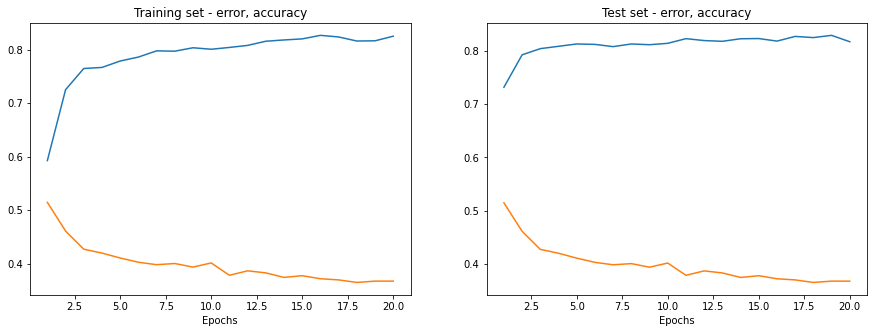

In [26]:
# display the plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Training set - error, accuracy')
axes[0].plot(x_training_accuracy, y_training_accuracy, label='Accuracy')
axes[0].plot(x_training_error, y_test_error, label='Error')
axes[0].set_xlabel('Epochs')

axes[1].set_title('Test set - error, accuracy')
axes[1].plot(x_test_accuracy, y_test_accuracy, label='Accuracy')
axes[1].plot(x_test_error, y_test_error, label='Error')
axes[1].set_xlabel('Epochs')

plt.show()

_The training and testing error is shown above in the left and right plots, respectively. As the number of Epochs increases, the total error decreases and the accuracy increases._

#### Possible upgrades

To further enhance and optimize this neural network model, one of a mixture of the following might be considered:

* `Increase the training sample size` from 1,000 to a higher number (up to 60,000).

* Use `mini-batches` and reduce the learning rate.

* Alter the architecture by introducing `more hidden layers` to make the network deeper.

* Combine the `cross-entropy` loss function with a softmax activation function in the last layer.

* Replace the feedforward network with a `convolutional neural network` (CNN) architecture.

* Use a higher epoch size to train longer and add more regularization techniques, such as `early stopping`, to prevent `overfitting`.

* Introduce a `validation set` for an unbiased valuation of the model fit.

* Apply `batch normalization` for faster and more stable training.

* `Tune other hyperparameters`, such as the learning rate and hidden layer size.